In [11]:
import wandb
import pandas as pd
import seaborn
api = wandb.Api()

In [2]:
runs = dict(
    dense=api.run("uwu1/modded-nanogpt-moe/iupmnz1q"),
    topk1_learned_neb10=api.run("uwu1/modded-nanogpt-moe/kba1m7vd"),
    topk1_learned_norm=api.run("uwu1/modded-nanogpt-moe/jt8y5rlo"),
    topk2_learned_norm=api.run("uwu1/modded-nanogpt-moe/pg4cinue"),
    topk1_learned=api.run("uwu1/modded-nanogpt-moe/q9jf69ae"),
)

In [3]:
histories = {k: pd.DataFrame.from_records(run.scan_history()) for k, run in runs.items()}

In [4]:
for name, history in histories.items():
    cfg = runs[name].config
    history["tokens"] = \
        (history["_step"] + 1) * cfg["training"]["batch_size_total"] * cfg["training"]["sequence_length"]

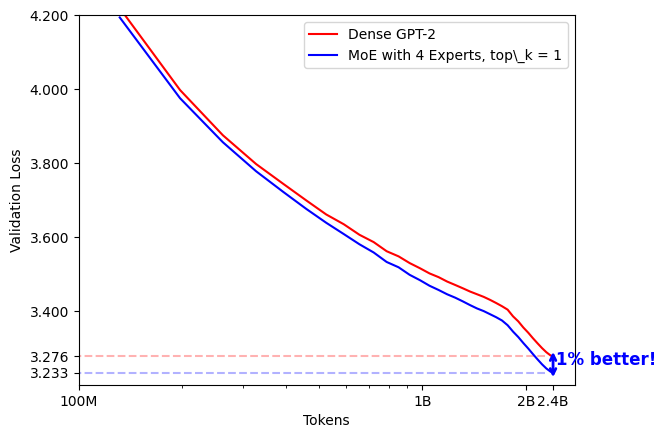

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
after_100M = {k: h[h["tokens"] > 100_000_000] for k, h in histories.items()}
topk1_min_loss = after_100M["topk1_learned_norm"]["val/loss"].min()
dense_min_loss = after_100M["dense"]["val/loss"].min()
plt.axhline(dense_min_loss, 0.94, 0.0, color="red", linestyle="dashed", alpha=0.3)
plt.axhline(topk1_min_loss, 0.94, 0.0, color="blue", linestyle="dashed", alpha=0.3)

seaborn.lineplot(data=after_100M["dense"], x="tokens", y="val/loss", label="Dense GPT-2", color="red").set(xscale='log')
seaborn.lineplot(data=after_100M["topk1_learned_norm"], x="tokens", y="val/loss", label="MoE with 4 Experts, top\_k = 1", color="blue").set(xscale='log')
dense_final = histories["dense"].iloc[-1]["val/loss"]  # Get last data point
# Draw arrow between curves
plt.annotate('', xy=(2_400_000_000, dense_final + 0.005*4), xytext=(2_400_000_000, topk1_min_loss - 0.005*4),
             arrowprops=dict(arrowstyle='<->', color='blue', lw=2))
#Draw arrow between curves with text
plt.annotate('1% better!', xy=(2_400_000_000, dense_final + 0.005), xytext=(2_450_000_000, (dense_final + topk1_min_loss) / 2),
             fontsize=12, fontweight='bold', color='blue', ha='left',
             )
ax = plt.gca()
ax.set_yticks([*ax.get_yticks()[2:], dense_min_loss, topk1_min_loss])
ax.set_xticks([100_000_000, 1_000_000_000, 2_000_000_000, 2_400_000_000],
              ["100M", "1B", "2B", "2.4B"])

ax.set_xlabel("Tokens")
ax.set_ylabel("Validation Loss")
ax.set_ylim((3.2, 4.2))
plt.savefig("dense_vs_topk1_learned_norm.svg")


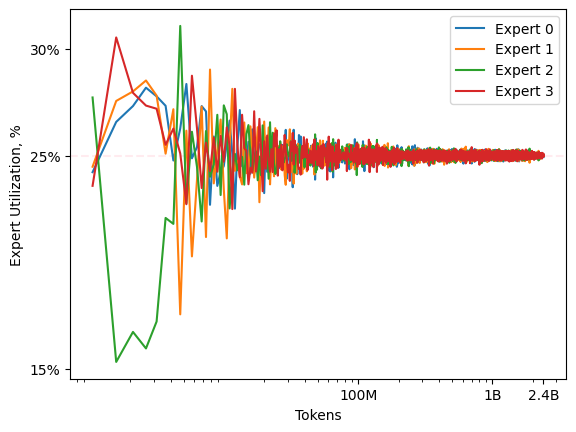

In [6]:
plt.rcParams['svg.fonttype'] = 'none'

plt.axhline(25, 0.0, 1.0, color="pink", linestyle="dashed", alpha=0.3)

for expert_idx in range(4):
    histories["topk1_learned_norm"][f"train/expert_balance/{expert_idx}_percent"] = histories["topk1_learned_norm"][f"train/expert_balance/{expert_idx}"] * 100
    seaborn.lineplot(data=histories["topk1_learned_norm"], x="tokens", y=f"train/expert_balance/{expert_idx}_percent", label=f"Expert {expert_idx}").set(xscale='log')


ax = plt.gca()
ax.set_xlabel("Tokens")
ax.set_ylabel("Expert Utilization, %")
ax.set_xticks([100_000_000, 1_000_000_000, 2_400_000_000],
              ["100M", "1B", "2.4B"])


ax.set_yticks([15, 25, 30], ["15%", "25%", "30%"])
plt.savefig("topk1_learned_norm_expert_util.svg")


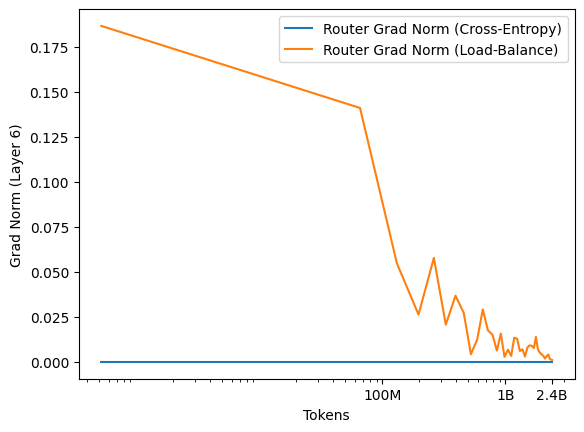

In [7]:
seaborn.lineplot(data=histories["topk1_learned_norm"], x="tokens", y="Router Grad Norms (CE)/Layer 6", label="Router Grad Norm (Cross-Entropy)")
seaborn.lineplot(data=histories["topk1_learned_norm"], x="tokens", y="Router Grad Norms (AUX)/Layer 6", label="Router Grad Norm (Load-Balance)")

ax = plt.gca()

ax.set_ylabel("Grad Norm (Layer 6)")
ax.set_xlabel("Tokens")
ax.set_xscale("log")
ax.set_xticks([100_000_000, 1_000_000_000, 2_400_000_000],
              ["100M", "1B", "2.4B"])



plt.savefig("topk1_learned_norm_router_grad.svg")


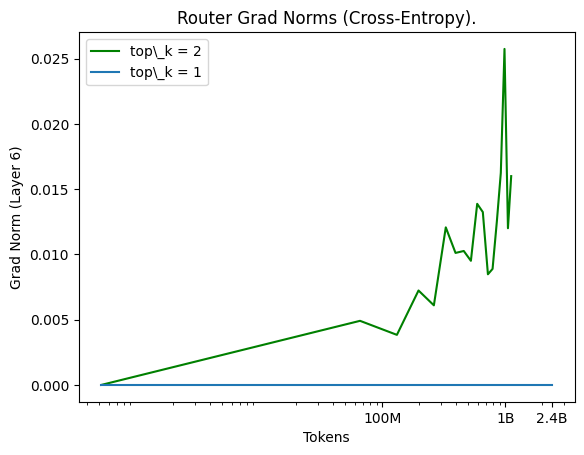

In [8]:
seaborn.lineplot(data=histories["topk2_learned_norm"], x="tokens", y="Router Grad Norms (CE)/Layer 6", label="top\_k = 2", color="green")
seaborn.lineplot(data=histories["topk1_learned_norm"], x="tokens", y="Router Grad Norms (CE)/Layer 6", label="top\_k = 1", )

ax = plt.gca()
ax.set_title("Router Grad Norms (Cross-Entropy).")
ax.set_ylabel("Grad Norm (Layer 6)")
ax.set_xlabel("Tokens")
ax.set_xscale("log")
ax.set_xticks([100_000_000, 1_000_000_000, 2_400_000_000],
              ["100M", "1B", "2.4B"])

plt.savefig("topk2_learned_norm_router_grad.svg")


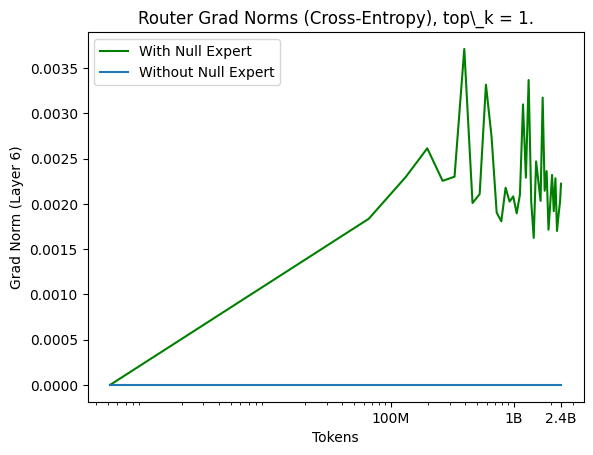

In [9]:
seaborn.lineplot(data=histories["topk1_learned_neb10"], x="tokens", y="Router Grad Norms (CE)/Layer 6", label="With Null Expert", color="green")
seaborn.lineplot(data=histories["topk1_learned_norm"], x="tokens", y="Router Grad Norms (CE)/Layer 6", label="Without Null Expert")
#seaborn.lineplot(data=histories["topk2_learned_norm"], x="tokens", y="Router Grad Norms (CE)/Layer 6", label="top_k 2")
ax = plt.gca()
ax.set_title("Router Grad Norms (Cross-Entropy), top\_k = 1.")
ax.set_ylabel("Grad Norm (Layer 6)")
ax.set_xlabel("Tokens")
ax.set_xscale("log")
ax.set_xticks([100_000_000, 1_000_000_000, 2_400_000_000],
              ["100M", "1B", "2.4B"])

plt.savefig("topk1_learned_norm_vs_neb_router_grad.svg")


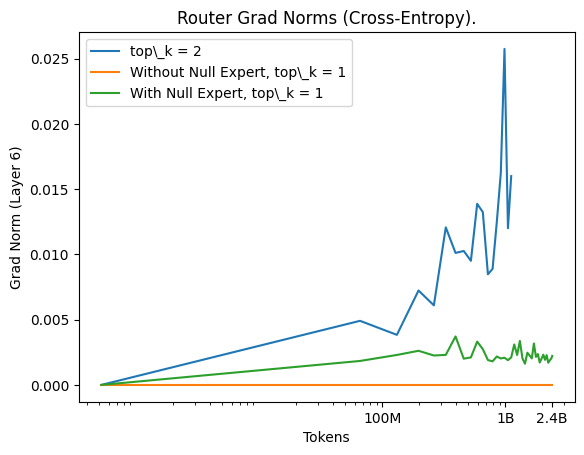

In [10]:
seaborn.lineplot(data=histories["topk2_learned_norm"], x="tokens", y="Router Grad Norms (CE)/Layer 6", label="top\_k = 2")
seaborn.lineplot(data=histories["topk1_learned_norm"], x="tokens", y="Router Grad Norms (CE)/Layer 6", label="Without Null Expert, top\_k = 1")

seaborn.lineplot(data=histories["topk1_learned_neb10"], x="tokens", y="Router Grad Norms (CE)/Layer 6", label="With Null Expert, top\_k = 1")
ax = plt.gca()
ax.set_title("Router Grad Norms (Cross-Entropy).")
ax.set_ylabel("Grad Norm (Layer 6)")
ax.set_xlabel("Tokens")
ax.set_xscale("log")
ax.set_xticks([100_000_000, 1_000_000_000, 2_400_000_000],
              ["100M", "1B", "2.4B"])

plt.savefig("topk1_learned_norm_vs_neb_vs_topk2_router_grad.svg")


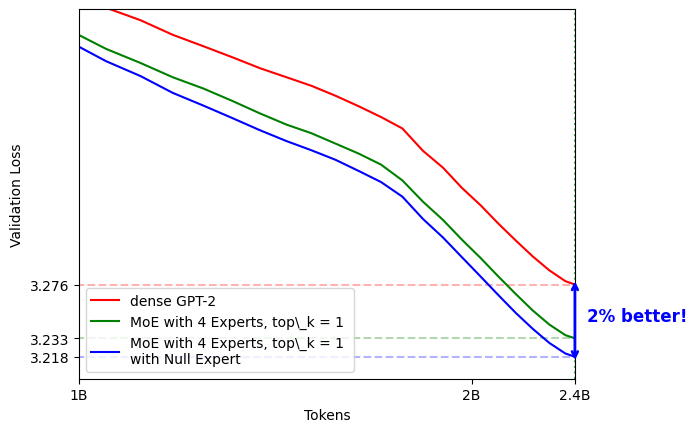

In [11]:
from matplotlib.ticker import FixedLocator
plt.rcParams['svg.fonttype'] = 'none'
topk1_neb_min_loss = histories["topk1_learned_neb10"]["val/loss"].min()

plt.axhline(dense_min_loss, 0.99, 0.0, color="red", linestyle="dashed", alpha=0.3)
plt.axhline(topk1_min_loss, 0.99, 0.0, color="green", linestyle="dashed", alpha=0.3)
plt.axhline(topk1_neb_min_loss, 0.99, 0.0, color="blue", linestyle="dashed", alpha=0.3)

seaborn.lineplot(data=histories["dense"], x="tokens", y="val/loss", label="dense GPT-2", color="red").set(xscale='log')
seaborn.lineplot(data=histories["topk1_learned_norm"], x="tokens", y="val/loss", label="MoE with 4 Experts, top\_k = 1", color="green").set(xscale='log')
seaborn.lineplot(data=histories["topk1_learned_neb10"], x="tokens", y="val/loss", label="MoE with 4 Experts, top\_k = 1 \nwith Null Expert", color="blue").set(xscale='log')
ax = plt.gca()

# Add vertical line and percent improvement annotation
plt.axvline(2_400_000_000, color="green", linestyle="dotted", alpha=0.7)
moe_final = histories["topk1_learned_neb10"].iloc[-1]["val/loss"]  # Get last data point
percent_improvement = ((dense_final - moe_final) / dense_final) * 100
# Draw arrow between curves
plt.annotate('', xy=(2_400_000_000, dense_final + 0.005), xytext=(2_400_000_000, moe_final - 0.005),
             arrowprops=dict(arrowstyle='<->', color='blue', lw=2))
#Draw arrow between curves with text
plt.annotate('2% better!', xy=(2_400_000_000, dense_final + 0.005), xytext=(2_450_000_000, (dense_final + moe_final) / 2),
             fontsize=12, fontweight='bold', color='blue', ha='left',
             )

ax.set_xlabel("Tokens")
ax.xaxis.set_major_locator(FixedLocator([1_000_000_000, 2_000_000_000, 2_400_000_000]))
ax.set_yticks([dense_min_loss, topk1_min_loss, topk1_neb_min_loss], [f"{x:.3f}" for x in [dense_min_loss, topk1_min_loss, topk1_neb_min_loss]])
ax.set_xlim((1_000_000_000, 2_400_000_000))
plt.xticks([1_000_000_000, 2_000_000_000, 2_400_000_000], ["1B", "2B", "2.4B"])
plt.minorticks_off()
ax.set_ylabel("Validation Loss")
ax.set_ylim((3.2, 3.5))
plt.savefig("dense_vs_topk1_learned_norm_vs_neb.svg")